In [1]:
"""
Created on 2018年10月18日

@author: STEVEN.CY.CHUANG
"""

from time import time
import unittest
import numpy as np
import pickle
import keras
from sklearn.metrics import silhouette_score

import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0" 

from keras.datasets import mnist
from keras.metrics import binary_accuracy
import tensorflow as tf
from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
# config.gpu_options.per_process_gpu_memory_fraction = 0.48
set_session(tf.Session(config=config))

import sys  
sys.path.append("../")
from util.util import *
from util import import_notebook
from module.autoencoder import *

Using TensorFlow backend.


importing Jupyter notebook from ../module/autoencoder.ipynb


In [2]:
class TestAE(unittest.TestCase):
    
    num_epochs = 10
    size_batch = 512
    size_kernel = 3
    lay_den_enc = [32, 8]
    name_optim = "adam"
    path_temp_best = "../model/temp/"
    patience = 3
    
    (x_train, y_train), (x_test, y_test) = mnist.load_data()
    x_train = x_train.astype("float32") / 255.
    x_test = x_test.astype("float32") / 255.
    num_train = len(x_train)
    num_test = len(x_test)
    size_digit = x_train.shape[1:]

    dim_input = np.prod(x_train.shape[1:])
    x_train = x_train.reshape((num_train, dim_input))
    x_test = x_test.reshape((num_test, dim_input))
    print(x_train.shape)
    print(x_test.shape)
    
    def test_init(self):
        print("Test for AE:")
        print("Test for init:")
        ae = AE(self.dim_input, lay_den_enc=self.lay_den_enc)
        ae.encoder.summary()
        ae.decoder.summary()
        ae.autoencoder.summary()
        self.ae = ae
        print("\r\n")
        
        
    def test_specific_decode(self):
        print("Test for specificdecode:")
        ae = AE(self.dim_input, lay_den_enc=self.lay_den_enc, lay_den_dec=[1, 4, 16])
        ae.fit(self.x_train, self.x_test, 
               num_epochs=5,
               patience=1,
               size_batch=1024,
               metrics=["binary_accuracy"],
               path_temp_best=self.path_temp_best)
        ae.encoder.summary()
        ae.decoder.summary()
        ae.autoencoder.summary()
        print("\r\n")

        
    def test_fit(self):
        print("Test for fitting:")
        history, time_train = self.ae.fit(self.x_train, self.x_test, 
                                         num_epochs=self.num_epochs,
                                         size_batch=self.size_batch,
                                         path_temp_best=self.path_temp_best
                                        )
        print("\r\n")
        
        
    def test_fit_check_best(self):
        print("Test for checking best fit:")
        history, time_train = self.ae.fit(self.x_train, self.x_test, 
                                         num_epochs=20,
                                         patience=1,
                                         size_batch=self.size_batch,
                                         metrics=["binary_accuracy"],
                                         path_temp_best=self.path_temp_best
                                        )
        # print the binary accuracy of testing dataset for verifying best model
        print(tf.keras.backend.eval(binary_accuracy(self.x_test, self.ae.autoencoder.predict(self.x_test))).mean())
        print("\r\n")
    
    
    def test_fit_check_verbose(self):
        print("Test for verbose:")
        history, time_train = self.ae.fit(self.x_train, self.x_test, 
                                         num_epochs=self.num_epochs,
                                         size_batch=self.size_batch,
                                         path_temp_best=self.path_temp_best,
                                         verb=0
                                        )
        history, time_train = self.ae.fit(self.x_train, self.x_test, 
                                         num_epochs=self.num_epochs,
                                         size_batch=self.size_batch,
                                         path_temp_best=self.path_temp_best,
                                         verb=1
                                        )
        history, time_train = self.ae.fit(self.x_train, self.x_test, 
                                         num_epochs=self.num_epochs,
                                         size_batch=self.size_batch,
                                         path_temp_best=self.path_temp_best,
                                         verb=2
                                        )
        print("\r\n")
    
    
    def test_save_seperate(self):
        print("Test for saving seperately:")
        self.ae.encoder.save("../model/test/AE/encoder.h5")
        self.ae.decoder.save("../model/test/AE/decoder.h5")
        print("\r\n")

        
    def test_save(self):
        print("Test for saving:")
        self.ae.save("../model/test/AE/ae")
        print("\r\n")
                
            
    def test_load_seperate(self):
        print("Test for loading seperately:")
        encoder = keras.models.load_model("../model/test/AE/encoder.h5")
        decoder = keras.models.load_model("../model/test/AE/decoder.h5")
#         autoencoder = keras.models.load_model("./temp/autoencoder.h5", custom_objects={"lossae": lossae})
        encoder.summary()
        decoder.summary()
#         autoencoder.summary()
        encode_test = encoder.predict(self.x_test)
        decode_test = decoder.predict(encode_test)
#         decode_test2 = autoencoder.predict(self.x_test)

#         Plot the comparison of original and reconstructed pictures, and calculate the errors
        plot_comp_decode(self.x_test, decode_test, size_digit=self.size_digit)
        err = comp_reconst(self.x_test, decode_test)
        print(err)
        print("\r\n")
        
        
    def test_load(self):
        print("Test for loading:")
        encoder, decoder, autoencoder = load("../model/test/AE/ae")
        encoder.summary()
        decoder.summary()
        autoencoder.summary()
        encode_test = encoder.predict(self.x_test)
        decode_test = decoder.predict(encode_test)
        
        # Plot the comparison of original and reconstructed pictures, and calculate the errors
        plot_comp_decode(self.x_test, decode_test, size_digit=self.size_digit)
        err = comp_reconst(self.x_test, decode_test)
        print(err)
        print("\r\n")
        
    
    def test_prediction(self):
        print("Test for prediction:")
        # Set the initialization
        x_test = self.x_test
        y_test = self.y_test
        size_digit = self.size_digit
        ae = self.ae
        encoder = ae.encoder
        decoder = ae.decoder
        
        # Get encoded and decoded values
        encode_test = encoder.predict(x_test)
        decode_test = decoder.predict(encode_test)
        mean_enc_test = np.mean(encode_test, axis=0)
        std_enc_test = np.std(encode_test, axis=0)
        
        # Plot the comparison of original and reconstructed pictures, and calculate the errors
        plot_comp_decode(x_test, decode_test, size_digit=size_digit)
        err = comp_reconst(x_test, decode_test)
        print(err)
        
        # Plot the scatter of the encoding space
        xlim = (mean_enc_test[0] - 4*std_enc_test[0], mean_enc_test[0] + 4*std_enc_test[0])
        ylim = (mean_enc_test[1] - 4*std_enc_test[1], mean_enc_test[1] + 4*std_enc_test[1])
        plot_scatter_encode(encode_test, y_test, xlim, ylim, num_show=10000)
        scoreSilh = silhouette_score(encode_test, y_test)    
        
        # Plot the decoding results from the encoding scatter
        plot_scatter_decode(decoder, size_digit, xlim, ylim)
        print("\r\n")

(60000, 784)
(10000, 784)


In [3]:

class TestConvAE(unittest.TestCase):
    
    num_epochs = 5
    size_batch = 512
    lay_den_enc = [8]
    lay_conv_enc = [4, 16]
    name_optim = "adam"
    path_temp_best = "../model/temp/"
    patience = 3
    
    (x_train, y_train), (x_test, y_test) = mnist.load_data()
    x_train = x_train.astype("float32") / 255.
    x_test = x_test.astype("float32") / 255.
    num_train = len(x_train)
    num_test = len(x_test)
    size_digit = x_train.shape[1:]
    dim_input = [*size_digit, 1]
    x_train = x_train.reshape((num_train, *dim_input))
    x_test = x_test.reshape((num_test, *dim_input))
    print(x_train.shape)
    print(x_test.shape)
    
    def test_init(self):
        print("Test for ConvAE:")
        print("Test for init:")
        conv_ae = ConvAE(self.dim_input, lay_den_enc=self.lay_den_enc, lay_conv_enc=self.lay_conv_enc)
        conv_ae.encoder.summary()
        conv_ae.decoder.summary()
        conv_ae.autoencoder.summary()
        self.conv_ae = conv_ae
        print("\r\n")
        
        
    def test_specific_decode(self):
        print("Test for specificdecode:")
        conv_ae = ConvAE(self.dim_input, lay_den_enc=self.lay_den_enc, lay_den_dec=[1, 4, 16])
        conv_ae.fit(self.x_train, self.x_test, 
                   num_epochs=5,
                   patience=1,
                   size_batch=1024,
                   metrics=["binary_accuracy"],
                   path_temp_best=self.path_temp_best)
        conv_ae.encoder.summary()
        conv_ae.decoder.summary()
        conv_ae.autoencoder.summary()
        print("\r\n")
        

    def test_fit(self):
        print("Test for fitting:")
        history, time_train = self.conv_ae.fit(self.x_train, self.x_test, 
                                              num_epochs=self.num_epochs,
                                              size_batch=self.size_batch,
                                              path_temp_best=self.path_temp_best)
        print("\r\n")
        
        
    def test_fit_check_best(self):
        print("Test for checking best fit:")
        history, time_train = self.conv_ae.fit(self.x_train, self.x_test, 
                                             num_epochs=20,
                                             patience=1,
                                             size_batch=self.size_batch,
                                             metrics=["binary_accuracy"],
                                             path_temp_best=self.path_temp_best)
        
        # print the binary accuracy of testing dataset for verifying best model
        print(tf.keras.backend.eval(binary_accuracy(self.x_test, self.conv_ae.autoencoder.predict(self.x_test))).mean())
        print("\r\n")
        
    
    def test_save_seperate(self):
        print("Test for saving seperately:")
        self.conv_ae.encoder.save("../model/test/ConvAE/encoder.h5")
        self.conv_ae.decoder.save("../model/test/ConvAE/decoder.h5")
        print("\r\n")

        
    def test_save(self):
        print("Test for saving:")
        self.conv_ae.save("../model/test/ConvAE/conv_ae")
        print("\r\n")
        
        
    def test_load_seperate(self):
        print("Test for loading seperately:")
        encoder = keras.models.load_model("../model/test/ConvAE/encoder.h5")
        decoder = keras.models.load_model("../model/test/ConvAE/decoder.h5")
#         autoencoder = keras.models.load_model("./temp/autoencoder.h5", custom_objects={"lossae": lossae})
        encoder.summary()
        decoder.summary()
#         autoencoder.summary()
        encode_test = encoder.predict(self.x_test)
        decode_test = decoder.predict(encode_test)
#         decodeTest2 = autoencoder.predict(self.x_test)
#         Plot the comparison of original and reconstructed pictures, and calculate the errors
        plot_comp_decode(self.x_test, decode_test, size_digit=self.size_digit)
        err = comp_reconst(self.x_test, decode_test)
        print(err)
        print("\r\n")
        
        
    def test_load(self):
        print("Test for loading:")
        encoder, decoder, autoencoder = load("../model/test/ConvAE/conv_ae")
        encoder.summary()
        decoder.summary()
        autoencoder.summary()
        encode_test = encoder.predict(self.x_test)
        decode_test = decoder.predict(encode_test)
        
        # Plot the comparison of original and reconstructed pictures, and calculate the errors
        plot_comp_decode(self.x_test, decode_test, size_digit=self.size_digit)
        err = comp_reconst(self.x_test, decode_test)
        print(err)
        print("\r\n")
        
    
    def test_prediction(self):
        print("Test for prediction:")
        # Set the initialization
        x_test = self.x_test
        y_test = self.y_test
        size_digit = self.size_digit
        ae = self.conv_ae
        encoder = ae.encoder
        decoder = ae.decoder
        
        # Get encoded and decoded values
        encode_test = encoder.predict(x_test)
        decode_test = decoder.predict(encode_test)
        mean_enc_test = np.mean(encode_test, axis=0)
        std_enc_test = np.std(encode_test, axis=0)
        
        # Plot the comparison of original and reconstructed pictures, and calculate the errors
        plot_comp_decode(x_test, decode_test, size_digit=size_digit)
        err = comp_reconst(x_test, decode_test)
        print(err)
        
        # Plot the scatter of the encoding space
        xlim = (mean_enc_test[0] - 4*std_enc_test[0], mean_enc_test[0] + 4*std_enc_test[0])
        ylim = (mean_enc_test[1] - 4*std_enc_test[1], mean_enc_test[1] + 4*std_enc_test[1])
        plot_scatter_encode(encode_test, y_test, xlim, ylim, num_show=10000)
        score_silh = silhouette_score(encode_test, y_test)
        print(score_silh) 
        
        # Plot the decoding results from the encoding scatter
        plot_scatter_decode(decoder, size_digit, xlim, ylim)
        print("\r\n")

(60000, 28, 28, 1)
(10000, 28, 28, 1)


In [4]:


class TestVAE(unittest.TestCase):
    
    num_epochs = 10
    size_batch = 512
    size_kernel = 3
    lay_den_enc = [32, 8]
    rat_recon = 1
    name_optim = "adam"
    path_temp_best = "../model/temp/"
    patience = 3
    
    (x_train, y_train), (x_test, y_test) = mnist.load_data()
    x_train = x_train.astype("float32") / 255.
    x_test = x_test.astype("float32") / 255.
    num_train = len(x_train)
    num_test = len(x_test)
    size_digit = x_train.shape[1:]

    dim_input = np.prod(x_train.shape[1:])
    x_train = x_train.reshape((num_train, dim_input))
    x_test = x_test.reshape((num_test, dim_input))
    print(x_train.shape)
    print(x_test.shape)
    
    def test_init(self):
        print("Test for VAE:")
        print("Test for init:")
        vae = VAE(self.dim_input, lay_den_enc=self.lay_den_enc, rat_recon=self.rat_recon)
        vae.encoder.summary()
        vae.decoder.summary()
        vae.autoencoder.summary()
        self.vae = vae
        print("\r\n")

        
    def test_fit(self):
        print("Test for fitting:")
        history, time_train = self.vae.fit(self.x_train, self.x_test, 
                                          num_epochs=self.num_epochs,
                                          size_batch=self.size_batch,
                                          path_temp_best=self.path_temp_best)
        print("\r\n")
        
        
    def test_fit_check_best(self):
        print("Test for checking best fit:")
        history, time_train = self.vae.fit(self.x_train, self.x_test, 
                                          num_epochs=20,
                                          patience = 1,
                                          size_batch=self.size_batch,
                                          metrics=["binary_accuracy"],
                                          path_temp_best=self.path_temp_best)
        print(tf.keras.backend.eval(binary_accuracy(self.x_test, self.vae.autoencoder.predict(self.x_test))).mean())
        print("\r\n")
        
    
    def test_save_seperate(self):
        print("Test for saving seperately:")
        self.vae.encoder.save("../model/test/VAE/encoder.h5")
        self.vae.decoder.save("../model/test/VAE/decoder.h5")
        print("\r\n")
        
        
    def test_save(self):
        print("Test for saving:")
        self.vae.save("../model/test/VAE/vae")
        print("\r\n")
        
        
    def test_load_seperate(self):
        print("Test for loading seperately:")
        encoder = keras.models.load_model("../model/test/VAE/encoder.h5")
        decoder = keras.models.load_model("../model/test/VAE/decoder.h5")
#         autoencoder = keras.models.load_model("./temp/autoencoder.h5", custom_objects={"lossVAE": lossVAE})
        encoder.summary()
        decoder.summary()
#         autoencoder.summary()
        encode_test = encoder.predict(self.x_test)
        decode_test = decoder.predict(encode_test)
        
        # Plot the comparison of original and reconstructed pictures, and calculate the errors
        plot_comp_decode(self.x_test, decode_test, size_digit=self.size_digit)
        err = comp_reconst(self.x_test, decode_test)
        print(err)
        print("\r\n")
        
        
    def test_load(self):
        print("Test for loading:")
        encoder, decoder, autoencoder = load("../model/test/VAE/vae")
        encoder.summary()
        decoder.summary()
        autoencoder.summary()
        encode_test = encoder.predict(self.x_test)
        decode_test = decoder.predict(encode_test)
        
        # Plot the comparison of original and reconstructed pictures, and calculate the errors
        plot_comp_decode(self.x_test, decode_test, size_digit=self.size_digit)
        err = comp_reconst(self.x_test, decode_test)
        print(err)
        print("\r\n")
        
    
    def test_prediction(self):
        print("Test for prediction:")
        # Set the initialization
        x_train = self.x_train
        x_test = self.x_test
        y_test = self.y_test
        size_digit = self.size_digit
        vae = self.vae
        encoder = vae.encoder
        decoder = vae.decoder
        
        # Get encoded and decoded values
        encode_test = encoder.predict(x_test)
        decode_test = decoder.predict(encode_test)
        mean_enc_test = np.mean(encode_test, axis=0)
        std_enc_test = np.std(encode_test, axis=0)
        
        # Plot the comparison of original and reconstructed pictures, and calculate the errors
        plot_comp_decode(x_test, decode_test, size_digit=size_digit)
        err = comp_reconst(x_test, decode_test)
        print(err)
        
        # Plot the scatter of the encoding space
        xlim = (mean_enc_test[0] - 4*std_enc_test[0], mean_enc_test[0] + 4*std_enc_test[0])
        ylim = (mean_enc_test[1] - 4*std_enc_test[1], mean_enc_test[1] + 4*std_enc_test[1])
        plot_scatter_encode(encode_test, y_test, xlim, ylim, num_show=10000)
        scoreSilh = silhouette_score(encode_test, y_test)    
        
        # Plot the decoding results from the encoding scatter
        plot_scatter_decode(decoder, size_digit, xlim, ylim)
        print("\r\n")

(60000, 784)
(10000, 784)


In [5]:
class TestConvVAE(unittest.TestCase):
    
    num_epochs = 10
    size_batch = 512
    size_kernel = 3
    lay_den_enc = [8]
    lay_conv_enc = [4, 16]
    rat_recon = 1
    name_optim = "adam"
    path_temp_best = "../model/temp/"
    patience = 3
    
    (x_train, y_train), (x_test, y_test) = mnist.load_data()
    x_train = x_train.astype("float32") / 255.
    x_test = x_test.astype("float32") / 255.
    num_train = len(x_train)
    num_test = len(x_test)
    size_digit = x_train.shape[1:]
    dim_input = [*size_digit, 1]
    x_train = x_train.reshape((num_train, *dim_input))
    x_test = x_test.reshape((num_test, *dim_input))
    print(x_train.shape)
    print(x_test.shape)
    
    def test_init(self):
        print("Test for ConvVAE:")
        print("Test for init:")
        conv_vae = ConvVAE(self.dim_input, lay_den_enc=self.lay_den_enc, lay_conv_enc=self.lay_conv_enc, rat_recon=self.rat_recon)
        conv_vae.encoder.summary()
        conv_vae.decoder.summary()
        conv_vae.autoencoder.summary()
        self.conv_vae = conv_vae
        print("\r\n")

    def test_fit(self):
        print("Test for fitting:")
        history, timeTrain = self.conv_vae.fit(self.x_train, self.x_test, 
                                              num_epochs=self.num_epochs,
                                              size_batch=self.size_batch,
                                              verb=1,
                                              path_temp_best=self.path_temp_best)
        print("\r\n")

        
    def test_save(self):
        print("Test for saving:")
        self.conv_vae.save("../model/test/ConvVAE/conv_vae")
        print("\r\n")
        
        
    def test_load(self):
        print("Test for loading:")
        encoder, decoder, autoencoder = load("../model/test/ConvVAE/conv_vae")
        encoder.summary()
        decoder.summary()
        autoencoder.summary()
        encode_test = encoder.predict(self.x_test)
        decode_test = decoder.predict(encode_test)
        
        # Plot the comparison of original and reconstructed pictures, and calculate the errors
        plot_comp_decode(self.x_test, decode_test, size_digit=self.size_digit)
        err = comp_reconst(self.x_test, decode_test)
        print(err)
        print("\r\n")
        
        
    def test_prediction(self):
        print("Test for prediction:")
        # Set the initialization
        x_test = self.x_test
        y_test = self.y_test
        size_digit = self.size_digit
        conv_vae = self.conv_vae
        encoder = conv_vae.encoder
        decoder = conv_vae.decoder
        
        # Get encoded and decoded values
        encode_test = encoder.predict(x_test)
        decode_test = decoder.predict(encode_test)
        mean_enc_test = np.mean(encode_test, axis=0)
        std_enc_test = np.std(encode_test, axis=0)
        
        # Plot the comparison of original and reconstructed pictures, and calculate the errors
        plot_comp_decode(x_test, decode_test, size_digit=size_digit)
        err = comp_reconst(x_test, decode_test)
        print(err)
        
        # Plot the scatter of the encoding space
        xlim = (mean_enc_test[0] - 4*std_enc_test[0], mean_enc_test[0] + 4*std_enc_test[0])
        ylim = (mean_enc_test[1] - 4*std_enc_test[1], mean_enc_test[1] + 4*std_enc_test[1])
        plot_scatter_encode(encode_test, y_test, xlim, ylim, num_show=10000)
        scoreSilh = silhouette_score(encode_test, y_test)  
        
        # Plot the decoding results from the encoding scatter
        plot_scatter_decode(decoder, size_digit, xlim, ylim)
        print("\r\n")

(60000, 28, 28, 1)
(10000, 28, 28, 1)


Test for ConvVAE:
Test for init:
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 14, 14, 4)    40          input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 14, 14, 4)    16          conv2d_1[0][0]                   
__________________________________________________________________________________________________
leaky_re_lu_1 (LeakyReLU)       (None, 14, 14, 4)    0           batch_normalization_1[0][0]      
____________________________________________________________________________

Epoch 8/10
60000/60000 [==============================] - 2s 32us/step - loss: 0.2422 - val_loss: 0.2630

Epoch 00008: val_loss improved from 0.26412 to 0.26298, saving model to ../model/temp//AutoEncoder1540547290.624671.hdf5
Epoch 9/10
60000/60000 [==============================] - 2s 32us/step - loss: 0.2395 - val_loss: 0.2592

Epoch 00009: val_loss improved from 0.26298 to 0.25920, saving model to ../model/temp//AutoEncoder1540547290.624671.hdf5
Epoch 10/10
60000/60000 [==============================] - 2s 31us/step - loss: 0.2377 - val_loss: 0.2545

Epoch 00010: val_loss improved from 0.25920 to 0.25452, saving model to ../model/temp//AutoEncoder1540547290.624671.hdf5


Test for prediction:


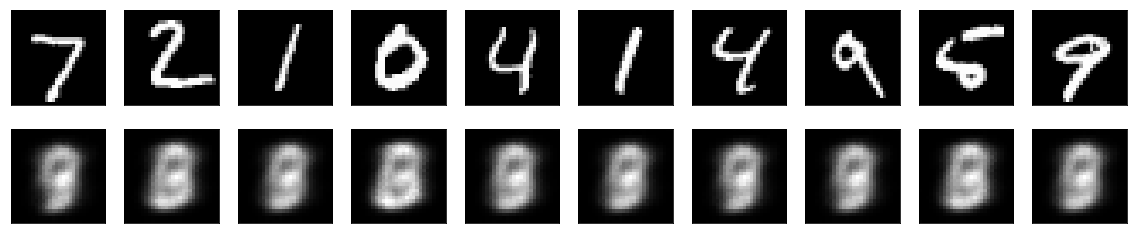

0.25489935


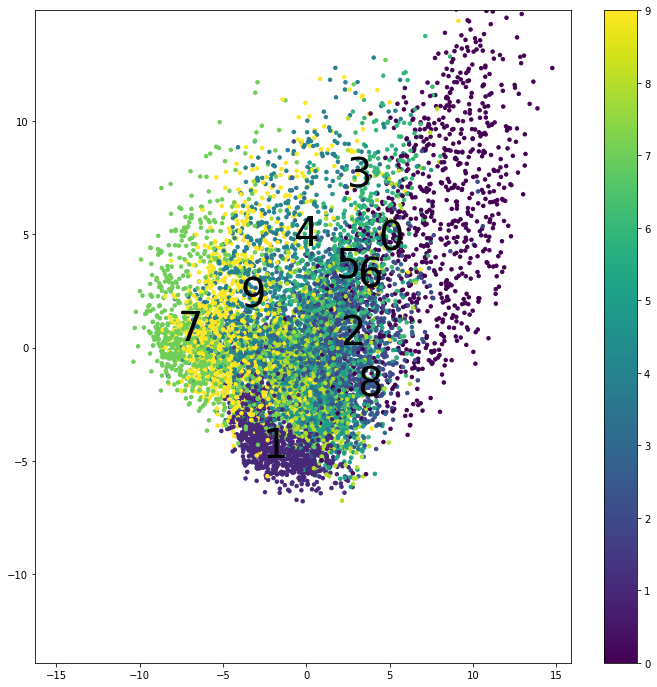

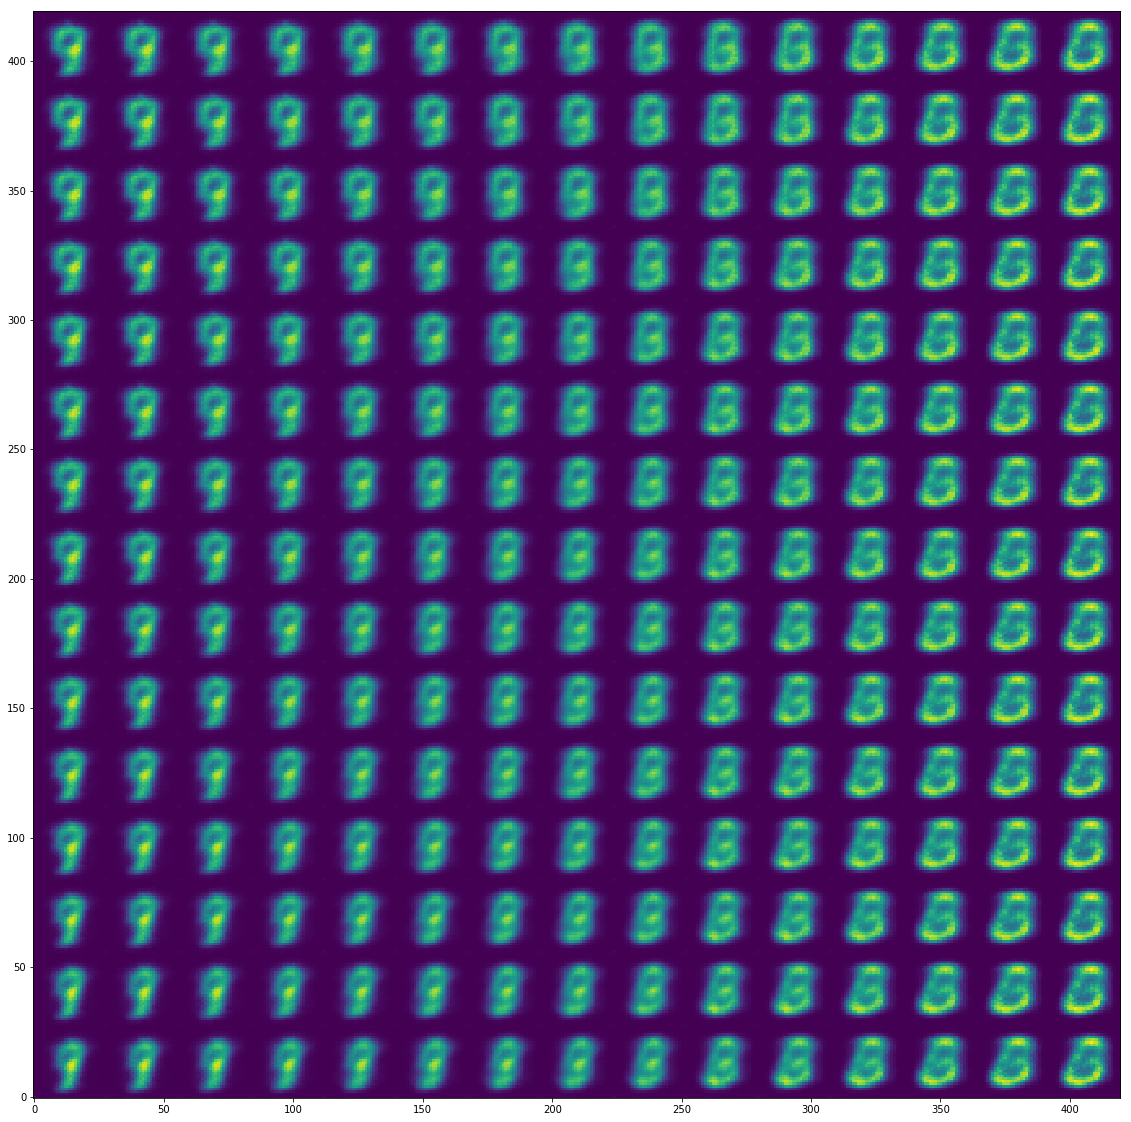



Test for saving:


Test for loading:
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 14, 14, 4)    40          input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 14, 14, 4)    16          conv2d_1[0][0]                   
__________________________________________________________________________________________________
leaky_re_lu_1 (LeakyReLU)       (None, 14, 14, 4)    0           batch_normalization_1[0][0]      
______________________________________________________________________

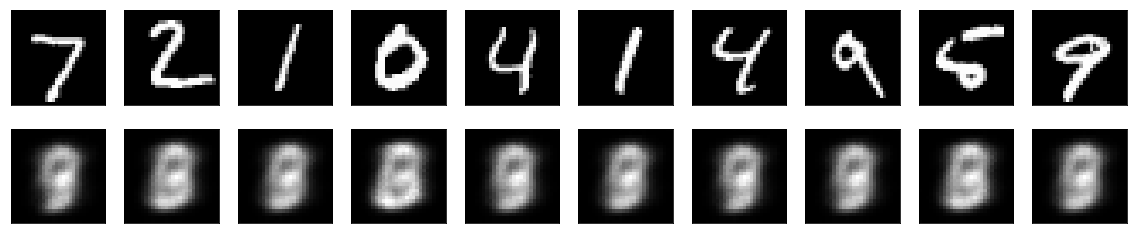

0.25489333




In [6]:
if __name__ == "__main__":
    testAE = TestAE()
    testAE.test_init()
    testAE.test_fit()
#     testAE.test_fit_check_best()
    testAE.test_fit_check_verbose()
    testAE.test_prediction()
    testAE.test_save()
    testAE.test_load()
    testAE.test_specific_decode()
     
    testConvAE = TestConvAE()
    testConvAE.test_init()
    testConvAE.test_fit()
#     testConvAE.test_fit_check_best()
    testConvAE.test_prediction()
    testConvAE.test_save()
    testConvAE.test_load()
    testConvAE.test_specific_decode()
    
    testVAE = TestVAE()
    testVAE.test_init()
    testVAE.test_fit()
#     testVAE.test_fit_check_best()
    testVAE.test_prediction()
    testVAE.test_save()
    testVAE.test_load()

    testConv = TestConvVAE()
    testConv.test_init()
    testConv.test_fit()
    testConv.test_prediction()
    testConv.test_save()
    testConv.test_load()

In [7]:
# from keras.datasets import mnist
# import numpy as np
# numEpochs = 2
# sizeBatch = 128
# sizeKernel = 3
# layerDense = [16, 2]
# ratRecon = 1
# nameOptim = 'adam'
# modelPath = '../model/temp/'
# patience = 3
# stdEps = 1.0

# (xTrain, yTrain), (xTest, yTest) = mnist.load_data()
# xTrain = xTrain.astype('float32') / 255.
# xTest = xTest.astype('float32') / 255.
# numTrain = len(xTrain)
# numTest = len(xTest)
# sizeDigit = xTrain.shape[1:]

# dimInput = np.prod(xTrain.shape[1:])
# xTrain = xTrain.reshape((numTrain, dimInput))
# xTest = xTest.reshape((numTest, dimInput))
# print(xTrain.shape)
# print(xTest.shape)


# layerDense=[64, 2] 
# actDense='relu'
# ratRecon=0.998
# dimEncode = layerDense[-1]

# inputs = Input(shape=(dimInput,)) 
# x = inputs

# # Stack of Dense layers
# for numFilt in layerDense[:-1]:
#     x = Dense(numFilt, activation=actDense)(x)
# zMean = Dense(dimEncode)(x)
# zSigmaLog = Dense(dimEncode)(x) # log for linear dense

# def sampling(args):
#     zMean, zSigmaLog = args
#     epsilon = K.random_normal(shape=(K.shape(zMean)[0], K.shape(zMean)[1]),
#                               mean=0., stddev=stdEps)
#     return zMean + K.exp(zSigmaLog) * epsilon  
    
# # Construct the latent as the output and build the encorder pipeline
# z = Lambda(sampling)([zMean, zSigmaLog])
# encoder = Model(inputs, z, name='encoder')

# # Build the Decoder Model
# inputLatent = Input(shape=(dimEncode,), name='decoder_input')
# x = inputLatent
# for numFilt in layerDense[-2::-1]:
#     x = Dense(numFilt, activation=actDense)(x)

# # Reconstruct the pixels as the output and build the decorder pipeline
# outputs = Dense(dimInput, activation='sigmoid', name='decoder_output')(x)
# decoder = Model(inputLatent, outputs, name='decoder')

# autoencoder = Model(inputs, decoder(encoder(inputs)), name='autoencoder')

# def lossVAE(tensorInput, tensorDecode):
#     zMean = zMean
#     zSigmaLog = zSigmaLog
#     ratRecon = ratRecon

#     lossRecon =  metrics.binary_crossentropy(K.flatten(tensorInput), K.flatten(tensorDecode))
# #         lossRecon =  metrics.mean_squared_error(K.flatten(tensorInput), K.flatten(tensorDecode))
#     lossKL = - 0.5 * K.sum(1 + 2 * zSigmaLog - K.square(zMean) - K.square(K.exp(zSigmaLog)), axis=-1)
#     return ratRecon * lossRecon + (1 - ratRecon) * lossKL

# autoencoder.compile(optimizer=nameOptim, loss=lossVAE)

# history = autoencoder.fit(xTrain, xTrain,
#                           epochs=numEpochs,
#                           batch_size=sizeBatch, shuffle=True,
#                           callbacks=callbacks,
#                           validation_data=(xValid, xValid)
#                          )
# vae.encoder.save('./encoder.h5')